# Nova VCF Results Visualization

This notebook creates comprehensive visualizations for nova variant detection analysis results.

In [10]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [93]:
# Load analysis results
results_json = "output/nova_variant_analysis.json"
results_csv = "output/nova_variant_analysis_tabular.csv"

with open(results_json, 'r') as f:
    results = json.load(f)

print(f"Loaded results from {results['metadata']['analysis_timestamp']}")
print(f"Total variants: {results['metadata']['total_nova_variants']}")
print(f"Overall detection rate: {results['metadata']['overall_detection_rate']:.1f}%")

Loaded results from 2025-06-25T16:46:36.869600
Total variants: 749
Overall detection rate: 107.3%


## 1. Detection Rates by Insertion Type

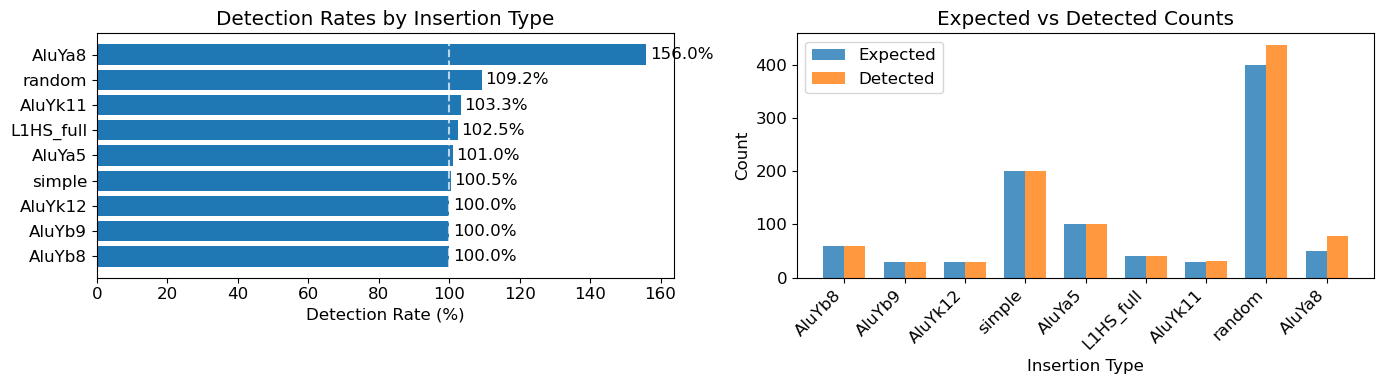

In [98]:
# Detection rates by insertion type
detection_data = results['detection_rates']

# Create DataFrame for easier plotting
detection_df = pd.DataFrame([
    {
        'insertion_type': ins_type,
        'expected': data['expected'],
        'detected': data['detected'],
        'rate': data['rate']
    }
    for ins_type, data in detection_data.items()
])

# Sort by detection rate
detection_df = detection_df.sort_values('rate', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

# Bar plot of detection rates
bars = ax1.barh(detection_df['insertion_type'], detection_df['rate'])
ax1.set_xlabel('Detection Rate (%)')
ax1.set_title('Detection Rates by Insertion Type')
ax1.axvline(x=100, color='white', linestyle='--', alpha=0.7)
# ax1.legend()

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center')

# Expected vs detected counts
x = np.arange(len(detection_df))
width = 0.35

ax2.bar(x - width/2, detection_df['expected'], width, label='Expected', alpha=0.8)
ax2.bar(x + width/2, detection_df['detected'], width, label='Detected', alpha=0.8)

ax2.set_xlabel('Insertion Type')
ax2.set_ylabel('Count')
ax2.set_title('Expected vs Detected Counts')
ax2.set_xticks(x)
ax2.set_xticklabels(detection_df['insertion_type'], rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()

## 2. Variant Composition Analysis

In [90]:
results_df = pd.read_csv(results_csv)
results_df.columns


Index(['variant_index', 'chrom', 'pos', 'svtype', 'svlen', 'precise',
       'support_reads', 'total_reads', 'nova_reads', 'nova_fraction',
       'is_single_read_call', 'support_level', 'nova_fraction_category',
       'precision_category', 'alignment_position_match', 'position_difference',
       'original_chrom', 'original_pos', 'modified_chrom', 'modified_pos',
       'nova_read_name', 'insertion_type', 'generated_size', 'size_difference',
       'size_ratio', 'exact_size_match', 'close_size_match',
       'reasonable_size_match'],
      dtype='object')

In [103]:
# Parallel category plot: SVTYPE → Precision → Success
fig = px.parallel_categories(
    results_df,
    dimensions=['insertion_type', 'svtype', 'nova_reads'],
    color = 'nova_fraction',
    title='Variant Flow',
    color_continuous_scale = 'viridis_r'
)

# SVTYPE → Sequence Content → Precision
fig.update_layout(autosize=False, width=800, height=500)
fig.show()

## 3. Successful Calls Analysis

NameError: name 'categories' is not defined

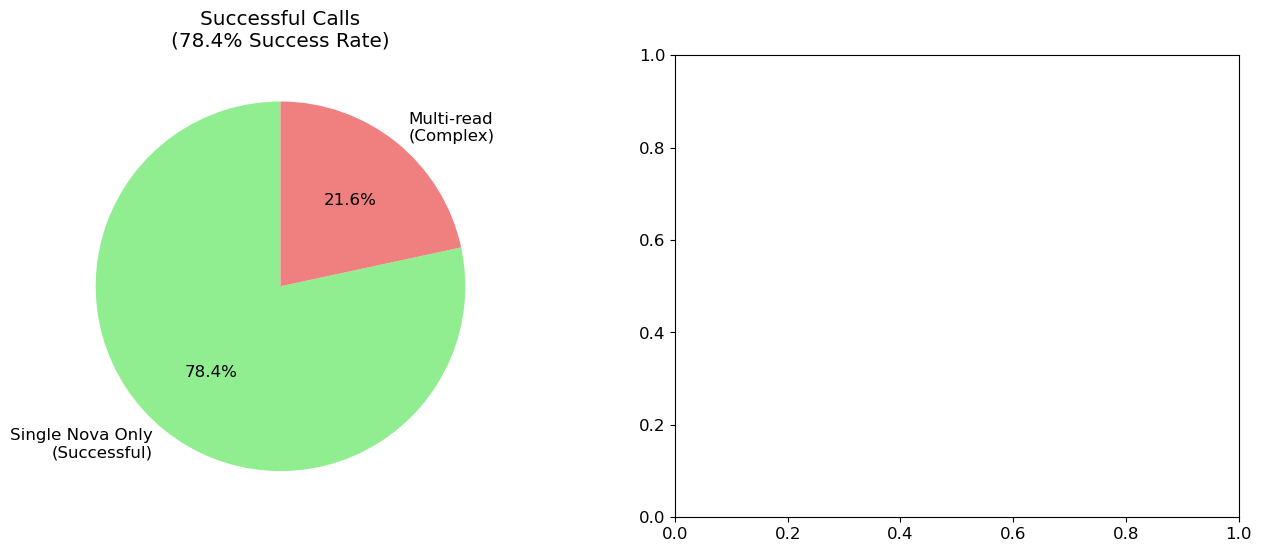

In [97]:
# Successful calls (single nova read only)
successful_calls = results['successful_calls']
success_rate = successful_calls['single_nova_only'] / successful_calls['total_variants'] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Success rate pie chart
success_counts = [
    successful_calls['single_nova_only'],
    successful_calls['total_variants'] - successful_calls['single_nova_only']
]
labels = ['Single Nova Only\n(Successful)', 'Multi-read\n(Complex)']
colors = ['lightgreen', 'lightcoral']

ax1.pie(success_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title(f'Successful Calls\n({success_rate:.1f}% Success Rate)')

# Read composition breakdown
read_comp_data = categories['by_read_composition']
# Focus on the most common categories
top_categories = dict(sorted(read_comp_data.items(), key=lambda x: x[1], reverse=True)[:8])

ax2.bar(range(len(top_categories)), list(top_categories.values()))
ax2.set_xticks(range(len(top_categories)))
ax2.set_xticklabels(list(top_categories.keys()), rotation=45, ha='right')
ax2.set_title('Read Composition Breakdown\n(Top 8 Categories)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 4. Alignment Position Analysis

In [ ]:
# Alignment analysis
if 'alignment_analysis' in results and results['alignment_analysis']:
    alignment_data = results['alignment_analysis']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Position match rate
    match_rate = alignment_data['match_rate']
    total_comparisons = alignment_data['total_comparisons']
    position_matches = alignment_data['position_matches']
    
    match_counts = [position_matches, total_comparisons - position_matches]
    labels = ['Position Match\n(±1kb)', 'Position Mismatch']
    colors = ['lightblue', 'lightcoral']
    
    ax1.pie(match_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title(f'Alignment Position Accuracy\n({match_rate:.1f}% Match Rate)')
    
    # Position differences histogram
    pos_diffs = alignment_data['position_differences']['values']
    if pos_diffs:
        # Filter out extreme outliers for better visualization
        filtered_diffs = [d for d in pos_diffs if d <= 10000]  # Within 10kb
        
        ax2.hist(filtered_diffs, bins=30, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Position Difference (bp)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Position Differences Distribution\n(≤10kb, n={len(filtered_diffs)})')
        ax2.axvline(x=np.median(filtered_diffs), color='red', linestyle='--', 
                   label=f'Median: {np.median(filtered_diffs):.0f}bp')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No alignment analysis data available")

## 5. Insertion Size Analysis

In [ ]:
# Size analysis
if 'size_analysis' in results and results['size_analysis']:
    size_data = results['size_analysis']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Size accuracy rates
    exact_rate = size_data['exact_rate']
    close_rate = size_data['close_rate']
    reasonable_rate = size_data['reasonable_rate']
    
    accuracy_categories = ['Exact\n(0bp diff)', 'Close\n(≤10bp diff)', 'Reasonable\n(≥80% ratio)']
    accuracy_rates = [exact_rate, close_rate, reasonable_rate]
    
    bars = ax1.bar(accuracy_categories, accuracy_rates, color=['darkgreen', 'green', 'lightgreen'])
    ax1.set_ylabel('Accuracy Rate (%)')
    ax1.set_title('Size Detection Accuracy')
    ax1.set_ylim(0, 100)
    
    # Add percentage labels
    for bar, rate in zip(bars, accuracy_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # Size differences histogram
    size_diffs = size_data['size_differences']['values']
    if size_diffs:
        # Filter out extreme outliers
        filtered_size_diffs = [d for d in size_diffs if d <= 100]  # Within 100bp
        
        ax2.hist(filtered_size_diffs, bins=20, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Size Difference (bp)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Size Differences Distribution\n(≤100bp, n={len(filtered_size_diffs)})')
        ax2.axvline(x=np.median(filtered_size_diffs), color='red', linestyle='--', 
                   label=f'Median: {np.median(filtered_size_diffs):.0f}bp')
        ax2.legend()
    
    # Size ratios histogram
    size_ratios = size_data['size_ratios']['values']
    if size_ratios:
        ax3.hist(size_ratios, bins=20, alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Size Ratio (min/max)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Size Ratios Distribution')
        ax3.axvline(x=np.median(size_ratios), color='red', linestyle='--', 
                   label=f'Median: {np.median(size_ratios):.2f}')
        ax3.legend()
    
    # Size accuracy by insertion type
    if 'by_insertion_type' in size_data:
        type_accuracy = size_data['by_insertion_type']
        
        types = list(type_accuracy.keys())
        exact_rates = [type_accuracy[t]['exact']/type_accuracy[t]['total']*100 
                      for t in types if type_accuracy[t]['total'] > 0]
        
        if exact_rates:
            ax4.bar(types, exact_rates)
            ax4.set_ylabel('Exact Match Rate (%)')
            ax4.set_title('Size Accuracy by Insertion Type')
            ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No size analysis data available")

## 6. Summary Statistics Dashboard

In [ ]:
# Create a summary dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Key metrics text
ax_text = fig.add_subplot(gs[0, :])
ax_text.axis('off')

summary_text = f"""
NOVA VARIANT DETECTION SUMMARY
Analysis Date: {results['metadata']['analysis_timestamp'][:10]}

• Total Variants with Nova Reads: {results['metadata']['total_nova_variants']:,}
• Overall Detection Rate: {results['metadata']['overall_detection_rate']:.1f}%
• Successful Calls (Single Nova Read): {successful_calls['single_nova_only']:,} ({success_rate:.1f}%)
"""

if 'alignment_analysis' in results and results['alignment_analysis']:
    summary_text += f"• Alignment Position Accuracy: {results['alignment_analysis']['match_rate']:.1f}%\n"

if 'size_analysis' in results and results['size_analysis']:
    summary_text += f"• Size Detection Accuracy (Exact): {results['size_analysis']['exact_rate']:.1f}%\n"

ax_text.text(0.05, 0.5, summary_text, fontsize=14, fontweight='bold', 
            transform=ax_text.transAxes, verticalalignment='center')

# Support reads distribution
ax1 = fig.add_subplot(gs[1, 0])
support_breakdown = categories['support_breakdown']
support_counts = [data['total'] for data in support_breakdown.values()]
support_labels = [f"{reads} reads" for reads in support_breakdown.keys()]

ax1.bar(range(len(support_counts)), support_counts)
ax1.set_xticks(range(len(support_labels)))
ax1.set_xticklabels(support_labels, rotation=45, ha='right')
ax1.set_title('Variants by Support Level')
ax1.set_ylabel('Count')

# Detection rates by type (top performing)
ax2 = fig.add_subplot(gs[1, 1])
top_detection = detection_df.nlargest(6, 'rate')
ax2.barh(top_detection['insertion_type'], top_detection['rate'])
ax2.set_xlabel('Detection Rate (%)')
ax2.set_title('Top Detection Rates')
ax2.axvline(x=100, color='red', linestyle='--', alpha=0.5)

# Nova fraction distribution
ax3 = fig.add_subplot(gs[1, 2])
nova_fractions = results['summary_statistics']['nova_fractions']['values']
if nova_fractions:
    ax3.hist(nova_fractions, bins=20, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Nova Read Fraction')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Nova Read Fraction Distribution')

# Performance summary table
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

# Create performance table
table_data = []
for ins_type, data in detection_data.items():
    table_data.append([
        ins_type,
        f"{data['expected']}",
        f"{data['detected']}",
        f"{data['rate']:.1f}%"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Insertion Type', 'Expected', 'Detected', 'Rate'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Detection Performance by Insertion Type', pad=20)

plt.show()

## 7. Export Figures

Uncomment the code below to save figures to files.

In [ ]:
# # Create output directory for figures
# output_dir = Path("output/figures")
# output_dir.mkdir(exist_ok=True)

# print(f"Figures saved to {output_dir}/")
# print("Rerun the plotting cells above to generate and save figures.")